In [7]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32
import nbimporter
import Toollib 

In [22]:
def noise(I,Noise):
    n_r,n_c = Noise.shape[0],Noise.shape[1]

    for i in range(n_r):
        for j in range(n_c):
            if(Noise[i, j,3]==0):
                continue
            for k in range(3):
                I[i,j,k] = Noise[i,j,k]

    return I

In [16]:
def AVGI(Graph):
    path = 'image/'+Graph
    I=io.imread(path +r'.tiff')
    Stego = I.copy()
    RT = Toollib.Sudoku(256)
    NearestP = Toollib.NearestPoint()

    p = 0
    MSE = 0
    F = 0
    N = 0
    X = 0

    for i in range(Stego.shape[0]):
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            ac = G_round    
            
            k = Toollib.Find(RT,NearestP,Stego[i,j,0],Stego[i,j,2],ac)          

            # print(f"i: {i} j: {j} k:{k}")
            # print(Stego[i,j,2],Stego[i,j+1,2],k)
            # print(f"i: {i}, j: {j}, I:({I[i,j,0]},{I[i,j,2]}), k:{k}")

            Stego[i,j,0] = k[0]
            Stego[i,j,2] = k[1]  
            g_bar = int((Gray - 0.299*k[0] - 0.114*k[1])/0.587)
            if(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) < round(Gray)):
                g_bar += 1
            elif(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) > round(Gray)):
                g_bar -= 1

            if(g_bar > 255):
                p += 1
                g_bar = 510 - abs(int((G_round - 0.299*k[0] - 0.114*k[1])/0.587))
            elif(g_bar < 0):
                p += 1
                g_bar = abs(int((G_round - 0.299*k[0] - 0.114*k[1])/0.587))
                
            Stego[i,j,1] = g_bar

            # print(f"I:{I[i,j]}, S:{Stego[i,j]}, g_bar:{(Gray - 0.299*k[0] - 0.114*k[1])/0.587}, k:{k}")

            X = 0
            delta = int(Stego[i,j,2]) - int(I[i,j,2])
            X += delta**2
            MSE += delta ** 2
            delta = int(Stego[i,j,1]) - int(I[i,j,1])
            X += delta**2
            MSE += delta ** 2 
            delta = int(Stego[i,j,0]) - int(I[i,j,0])
            X += delta**2           
            MSE += delta ** 2    
            if(X > 128):
                N += 1                                    

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p} , X:{N}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)

In [2]:
def Authorize(Graph):
    path = "embeding_noise/"+Graph+".png"

    I=io.imread(path)
    Stego = I.copy()
    RT = Toollib.Sudoku(256)
    Flag = False

    for i in range(Stego.shape[0]):
        # if(Flag):
        #     break
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            ac = G_round
            flag = False
            if(ac > RT[Stego[i,j,0],Stego[i,j,2]]):
                ac = abs(int((RT[Stego[i,j,0],Stego[i,j,2]] - 0.299*Stego[i,j,0] - 0.114*Stego[i,j,2])/0.587))
                if(Stego[i,j,1] != ac):
                    Stego[i,j,0] = 255
                    Stego[i,j,1] = 255
                    Stego[i,j,2] = 255
                    flag = True
                    # print(f"This picture is tampered. i: {i} ,j: {j} ,Stego:{Stego[i,j]} ,Gray:{Gray}, RT:{RT[Stego[i,j,0],Stego[i,j,2]]}")
                    # Flag = True
                    # break 
            elif(ac < RT[Stego[i,j,0],Stego[i,j,2]]):
                ac = 510 - abs(int((RT[Stego[i,j,0],Stego[i,j,2]] - 0.299*Stego[i,j,0] - 0.114*Stego[i,j,2])/0.587))
                if(Stego[i,j,1] != ac):                
                    Stego[i,j,0] = 255
                    Stego[i,j,1] = 255
                    Stego[i,j,2] = 255
                    flag = True
                    # print(f"This picture is tampered. i: {i} ,j: {j} ,Stego:{Stego[i,j]} ,Gray:{Gray}, RT:{RT[Stego[i,j,0],Stego[i,j,2]]}")
                    # Flag = True
                    # break  
            if(not flag):
                Stego[i,j,0] = 0
                Stego[i,j,1] = 0
                Stego[i,j,2] = 0
    io.imshow(Stego, vmin=0, vmax=255)
     
    plt.show()  # 不调用 tight_layout
    # if(not Flag):
    #     print("This picture is not tampered.")

              

In [19]:
def embeding(image,n):
    path = "processing_image/"+image+".png"
    I=io.imread(path)
    path2 = "noise/"+n+".png"
    I2=io.imread(path2)

    print(I2[0,0])
    print(I2[4,25])
    e = noise(I,I2)

    io.imshow(e)
    io.imsave('embeding_noise/'+image+'.png',e)     

PSNR:35.69007586390463 , F:7530


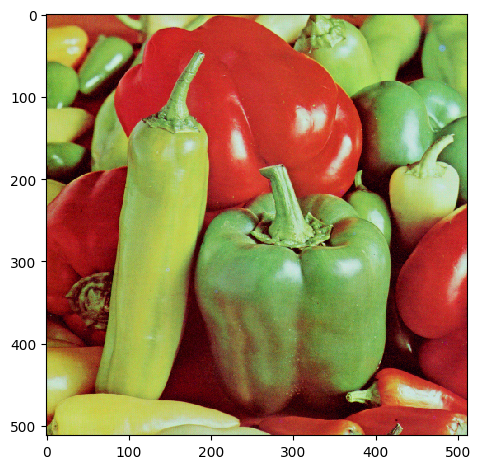

In [17]:
Toollib.AVGI('Peppers')

[0 0 0 0]
[0 0 0 0]


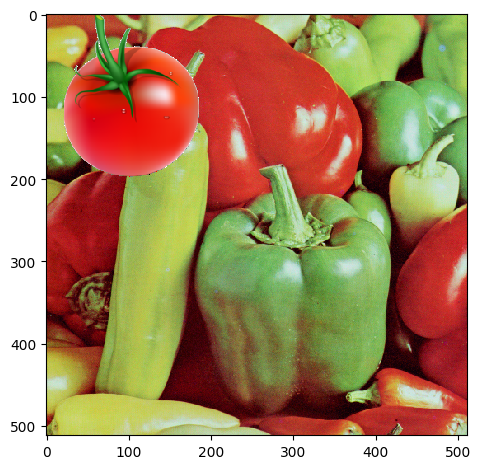

In [23]:
embeding("Peppers","tomato")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


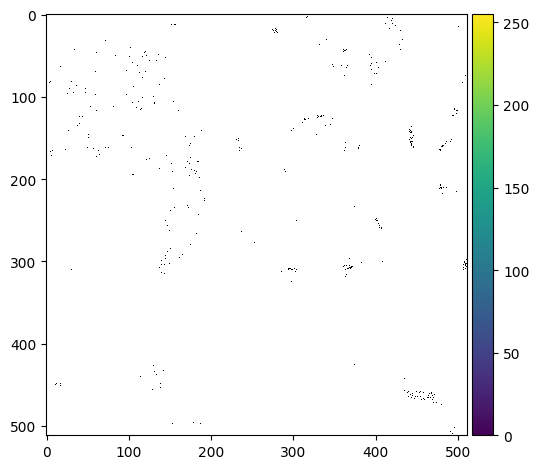

In [28]:
Authorize('Peppers')
# path = 'image/Peppers'
# I=io.imread(path +r'.tiff')
# RT = APPM_RT256()
# i = 32
# j = 456
# Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114

# G_round = round(Gray)
# ac = G_round


# g_bar = int((Gray - 0.299*47 - 0.114*9)/0.587)
# print(g_bar)
# print(I[i,j,0],I[i,j,1],I[i,j,2],Gray,RT[I[i,j,0],I[i,j,2]])

# print()

In [24]:
# path = 'image/Peppers'
# i = 23
# j = 0
# I=io.imread(path +r'.tiff')
# RT = APPM_RT256()
# Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114

# G_round = round(Gray)
# ac = hashB(np.array([G_round]),8)  
# num = fold(ac,2)

# g_bar = int(round((Gray - 0.299*68 - 0.114*57)/0.587))
# print(g_bar,(Gray - 0.299*68 - 0.114*57)/0.587)
# print(I[i,j,0],I[i,j,1],I[i,j,2],Gray)
# print(ac,num)
# print(remedy(I[i,j,0],I[i,j,1],I[i,j,2],num))